Predecir la aprobación de préstamos
**Resumen: Crear y evaluar un modelo que replica la decisión de aprobación de un
préstamo sin utilizar el "CIBIL" - con el fin de reemplazar el CIBIL**
Trabajamos en un banco - en el departamento de préstamos. Intentamos NUNCA aprobar
préstamos que pensamos que vayan a hacer un impago.
Hasta ahora la empresa ha pagado para tener un "credit score" de los que vienen solicitando un
préstamo. Esto se llama el "CIBIL".
Básicamente - cuando un agente recibe una solicitud para un préstamo, mira el CIBIL y decide
si aprobar el préstamo o no.
Tenemos que pagar por cada solicitud para recibir el CIBIL - bajando la rentabilidad. Entonces
nos han pedido buscar una alternativa al CIBIL.
Básicamente - queremos crear un modelo que sea capaz de predecir si un agente habría
finalmente aprobado el préstamo o no. Si conseguimos un modelo que acierta bastante -
podemos asumir que hemos replicado la utilidad del CIBIL y dejar de pagarlo.

Tenemos datos de varias solicitudes con las siguientes factores:
● loan_id: Identificador único para cada solicitud de préstamo.
● no_of_dependents: Número de dependientes del solicitante.
● education: Nivel educativo del solicitante.
● self_employed: Estado de empleo del solicitante (Si es autónomo o no).
● income_annum: Ingreso anual del solicitante.
● loan_amount: Cantidad de dinero del préstamo solicitado.
● loan_term: Plazo del préstamo en meses.
● cibil_score: Puntuación de crédito del solicitante - el CIBIL.
● residential_assets_value: Valor de los activos residenciales del solicitante.
● commercial_assets_value: Valor de los activos comerciales del solicitante.
● luxury_assets_value: Valor de los activos de lujo del solicitante.
● bank_asset_value: Valor de los activos bancarios del solicitante.
● loan_status: Estado de aprobación del préstamo (Aprobado/Rechazado).  

Puntos importantes y cosas que podemos asumir:
● No podemos utilizar el CIBIL en el modelo, pero sí que podemos utilizarlo para
ayudarnos a determinar factores importantes
● La moneda es rupees indios - podemos asumir que el cambio es 1€ = 90 INR
● Por solicitud pagamos aproximadamente 100€ para el CIBIL
● Asumimos que cada solicitud aprobado por el agente NO tienen impagos y todos los
que no se aprobaron SÍ que tuvieron un impago
● Asumimos que cada préstamo tiene un interés del 5% por año
● Los impagos suelen pasar por la mitad del préstamo
● Cuando tiene un préstamo un impago - conseguimos reclamar el dinero, pero cuesta el
proceso unos 10,000€
● Los impagos también tienen efectos negativos a largo plazo más difíciles de cuantificar
(acumular mucho riesgo puede salir muy mal)

# Import libraries and dependencies

In [247]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

RANDOM_SEED = 2_055
VALIDATION_SIZE = 0.2

pd.options.display.float_format = '{:.2f}'.format  # Not using scientific notation for better readability

# Exploratory data analysis

### Load the dataset

In [248]:
loans_df = pd.read_csv('./loan_approval_dataset.csv', index_col='loan_id')

In [249]:
# Remove leading and trailing spaces from columns and values
loans_df.columns = loans_df.columns.str.strip()
loans_df = loans_df.map(lambda x: x.strip() if isinstance(x, str) else x)

In [250]:
loans_df

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
loan_id,,,,,,,,,,,,
1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected
...,...,...,...,...,...,...,...,...,...,...,...,...
4265,5,Graduate,Yes,1000000,2300000,12,317,2800000,500000,3300000,800000,Rejected
4266,0,Not Graduate,Yes,3300000,11300000,20,559,4200000,2900000,11000000,1900000,Approved
4267,2,Not Graduate,No,6500000,23900000,18,457,1200000,12400000,18100000,7300000,Rejected


### Dataset information

In [251]:
loans_df.shape

(4269, 12)

In [252]:
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4269 entries, 1 to 4269
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   no_of_dependents          4269 non-null   int64 
 1   education                 4269 non-null   object
 2   self_employed             4269 non-null   object
 3   income_annum              4269 non-null   int64 
 4   loan_amount               4269 non-null   int64 
 5   loan_term                 4269 non-null   int64 
 6   cibil_score               4269 non-null   int64 
 7   residential_assets_value  4269 non-null   int64 
 8   commercial_assets_value   4269 non-null   int64 
 9   luxury_assets_value       4269 non-null   int64 
 10  bank_asset_value          4269 non-null   int64 
 11  loan_status               4269 non-null   object
dtypes: int64(9), object(3)
memory usage: 433.6+ KB


In [253]:
loans_df.describe()

,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
count,4269.00,4269.00,4269.00,4269.00,4269.00,4269.00,4269.00,4269.00,4269.00
mean,2.50,5059123.92,15133450.46,10.90,599.94,7472616.54,4973155.31,15126305.93,4976692.43
std,1.70,2806839.83,9043362.98,5.71,172.43,6503636.59,4388966.09,9103753.67,3250185.31
min,0.00,200000.00,300000.00,2.00,300.00,-100000.00,0.00,300000.00,0.00
25%,1.00,2700000.00,7700000.00,6.00,453.00,2200000.00,1300000.00,7500000.00,2300000.00
50%,3.00,5100000.00,14500000.00,10.00,600.00,5600000.00,3700000.00,14600000.00,4600000.00
75%,4.00,7500000.00,21500000.00,16.00,748.00,11300000.00,7600000.00,21700000.00,7100000.00
max,5.00,9900000.00,39500000.00,20.00,900.00,29100000.00,19400000.00,39200000.00,14700000.00


In [254]:
loans_df.isnull().sum()

no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

After a quick look at the dataset, we can see that it has been loaded correctly, there was a minor error on a space at the very start of every column name and string data, but it was fixed. There are no missing values and all the columns are what we could expect from it.

# Data analysis

### Target variable

The very first step will be visualizing the target variable (loan_status) to see its distribution. 

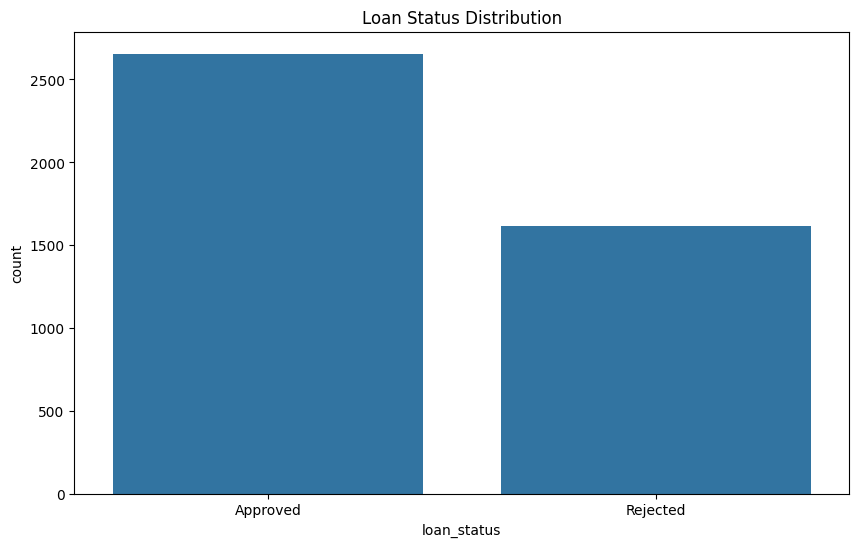

In [255]:
plt.figure(figsize=(10, 6))
sns.countplot(x='loan_status', data=loans_df)
plt.title(f'Loan Status Distribution')
plt.show()

In [256]:
loans_df['loan_status'].value_counts(normalize=True)

loan_status
Approved   0.62
Rejected   0.38
Name: proportion, dtype: float64

As we can see, there are around 2/3 of the loans that were approved and 1/3 that were rejected. This distribution is pretty decent (not too unbalanced). it will probably not be necessary to balance it by hand, but it is something to keep in mind when we make predictions and get the metrics.

### Categorical features

The first features we will explore are data, how it is distributed, and if there is any correlation with the loan status. For this problem, I will consider the number of dependants as a categorical variable, even if it is a number, it could easily be converted to a category (none, some, many) for example.

**no_of_dependents**

In [257]:
loans_df['no_of_dependents'].value_counts(normalize=True)

no_of_dependents
4   0.18
3   0.17
0   0.17
2   0.17
1   0.16
5   0.16
Name: proportion, dtype: float64

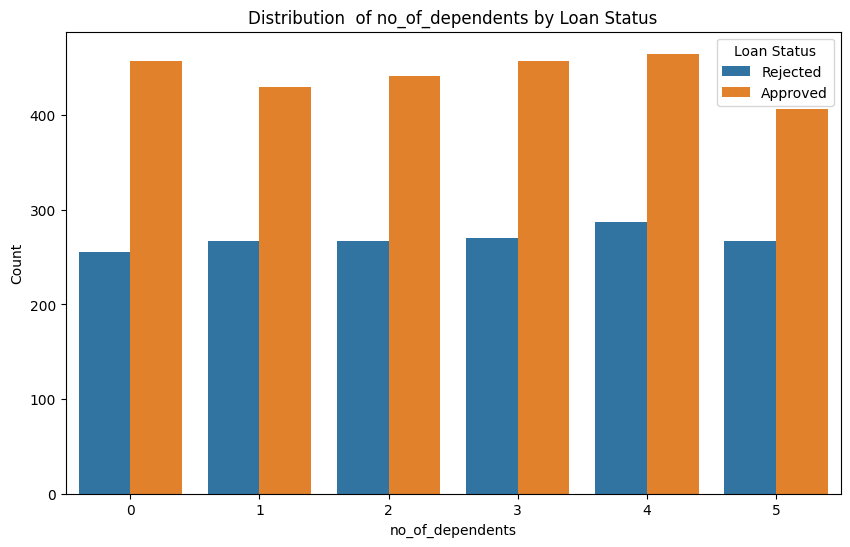

In [258]:
plt.figure(figsize=(10, 6))
sns.countplot(x='no_of_dependents', hue='loan_status', data=loans_df)
plt.title(f'Distribution  of no_of_dependents by Loan Status')
plt.xlabel('no_of_dependents')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.show()

**education**

In [259]:
loans_df['education'].value_counts(normalize=True)

education
Graduate       0.50
Not Graduate   0.50
Name: proportion, dtype: float64

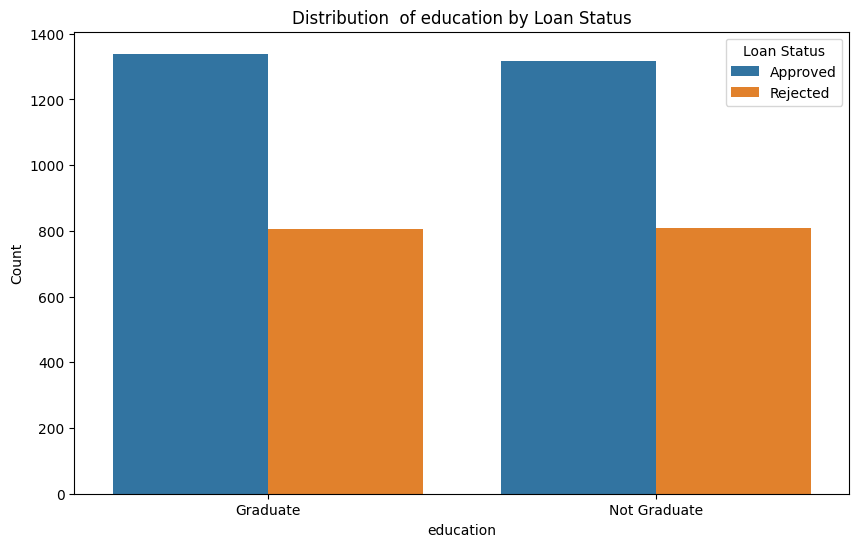

In [260]:
plt.figure(figsize=(10, 6))
sns.countplot(x='education', hue='loan_status', data=loans_df)
plt.title(f'Distribution  of education by Loan Status')
plt.xlabel('education')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.show()

**self_employed**

In [261]:
loans_df['self_employed'].value_counts(normalize=True)

self_employed
Yes   0.50
No    0.50
Name: proportion, dtype: float64

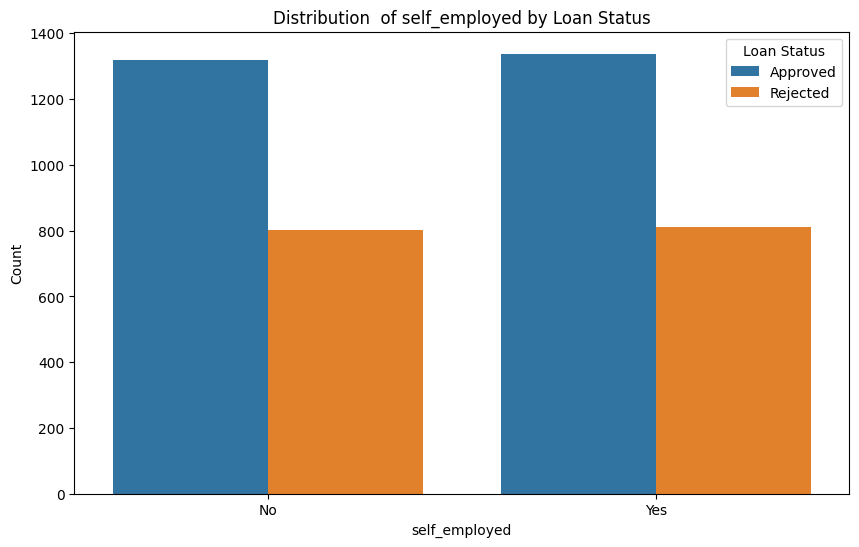

In [262]:
plt.figure(figsize=(10, 6))
sns.countplot(x='self_employed', hue='loan_status', data=loans_df)
plt.title(f'Distribution  of self_employed by Loan Status')
plt.xlabel('self_employed')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.show()

As the plots and the tables show, all three categorical features have the same distribution and same correlation with the target variable. This means that the loan status is not affected by the number of dependants, the education level, or if the person is self-employed or not. **So basically, they seem pretty much useless**.

### Numerical features

The next step will be to analyze the numerical features, see their distribution, and if there is any correlation with the target variable.

Even if it could be a bold assumption, we will consider all the assists as a single feature because, at the end of the day, all of them translates to the same thing: how much money the person has.

In [263]:
loans_df['total_assets'] = loans_df['residential_assets_value'] + loans_df['commercial_assets_value'] + loans_df[
    'luxury_assets_value'] + loans_df['bank_asset_value']

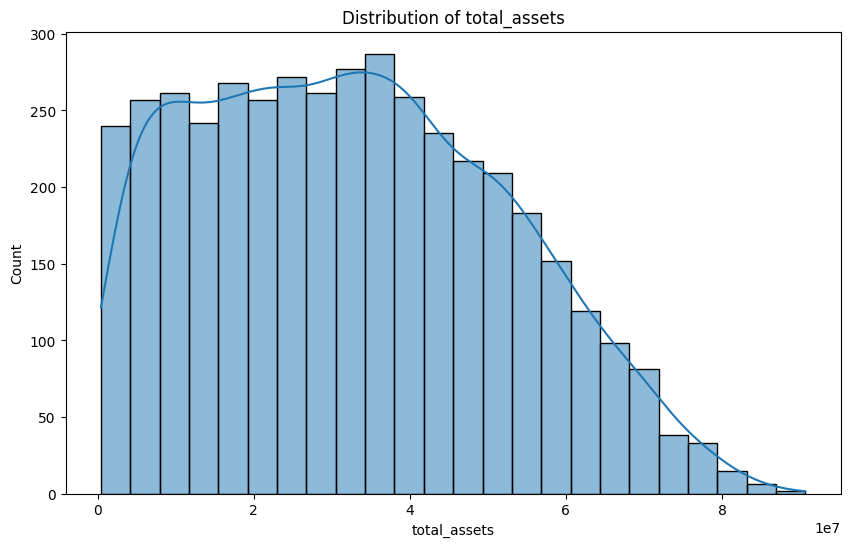

In [264]:
plt.figure(figsize=(10, 6))
sns.histplot(loans_df['total_assets'], kde=True)
plt.title(f'Distribution of total_assets')
plt.show()

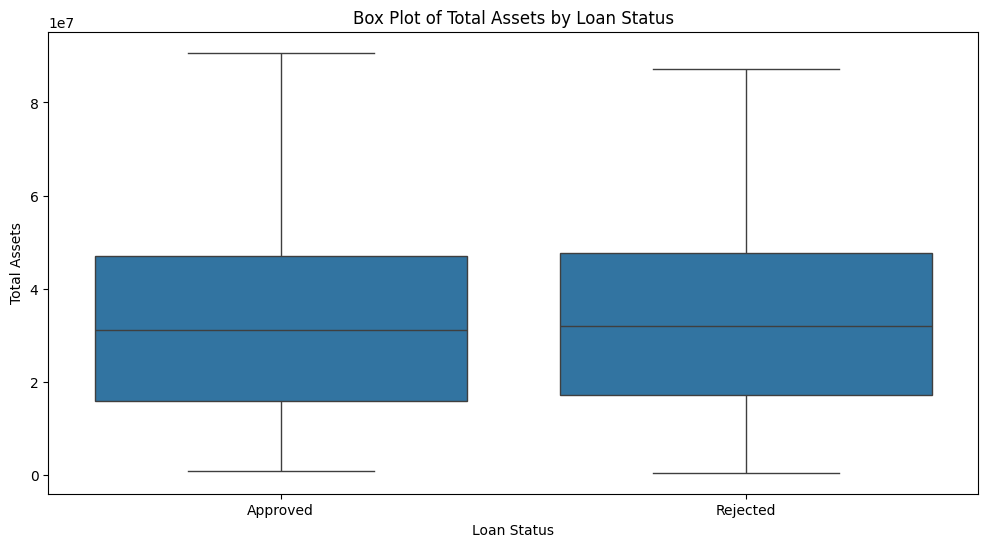

In [265]:
loans_df['loan_status_numeric'] = loans_df['loan_status'].apply(lambda x: 1 if x == 'Approved' else 0)

plt.figure(figsize=(12, 6))
sns.boxplot(x='loan_status', y='total_assets', data=loans_df)
plt.title('Box Plot of Total Assets by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Total Assets')
plt.show()

In [266]:
loans_df[['total_assets', 'loan_status_numeric']].corr()

,total_assets,loan_status_numeric
total_assets,1.00,-0.01
loan_status_numeric,-0.01,1.00


As we can see, adding the assists doesn't seem to indicate a wealthy person has a higher chance of getting a loan. The correlation is pretty much non-existent, and therefore it is not a good feature to use.

Now we will analyze the rest of the numerical features.

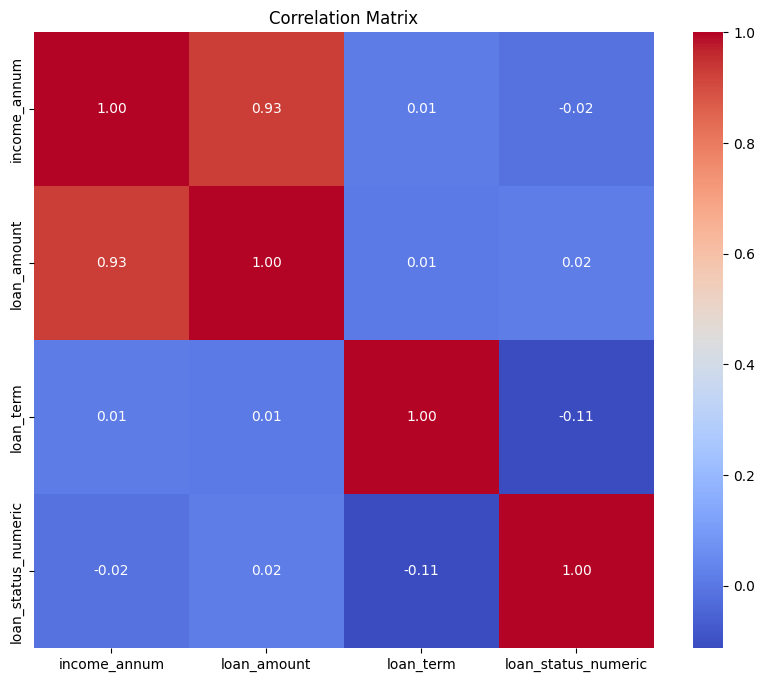

In [267]:
numerical_features = ['income_annum', 'loan_amount', 'loan_term']

# Calculate correlation matrix
correlation_matrix = loans_df[numerical_features + ['loan_status_numeric']].corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Looking at the matrix we can mainly see 2 things:
    - There is barely no correlation between the numerical features and the target variable
    - There is a high correlation between the loan amount and the loan term, which is expected.

# Feature engineering

After a simple analysis, we can see the features are rather poor, with litte realation with the target. Let's see if we can create new features that could help the model.

The first variable we will make will be the ratio of income by the number of dependant.

In [268]:
loans_df['income_dependants_ratio'] = loans_df['income_annum'] / (
        loans_df['no_of_dependents'] + 1)  # +1 to avoid division by 0

loans_df[['income_dependants_ratio', 'loan_status_numeric']].corr()

,income_dependants_ratio,loan_status_numeric
income_dependants_ratio,1.00,0.01
loan_status_numeric,0.01,1.00


Does not seem to be relevant either.

Next feature will be the ratio of the loan amount by the income. Might be able to tell us if the person is asking for too much money compared to their salary.

In [269]:
loans_df['loan_income_ratio'] = loans_df['loan_amount'] / loans_df['income_annum']

loans_df[['loan_income_ratio', 'loan_status_numeric']].corr()

,loan_income_ratio,loan_status_numeric
loan_income_ratio,1.00,0.09
loan_status_numeric,0.09,1.00


This feature seems to have a little correlation with the target variable. At this point, I will take it.

The last feature I will try is the ratio of the loan amount by the total assets. Let's see how the loan compares to all their properties

In [270]:
loans_df['loan_assets_ratio'] = loans_df['loan_amount'] / loans_df['total_assets']

loans_df[['loan_assets_ratio', 'loan_status_numeric']].corr()

,loan_assets_ratio,loan_status_numeric
loan_assets_ratio,1.00,0.03
loan_status_numeric,0.03,1.00


Again, extremely low correlation. Useless.

** Data analysis conclusion  **
It seems really hard to find the right feature which have correlation with the model. We will try to use the features we have and see if the model can find a pattern.

### Data preparation

In order to prepare the data for the model we will first select the features that seem the most relevant.

In [271]:
chosen_features = ['income_annum', 'loan_amount', 'loan_term', 'loan_income_ratio']
target_feature = 'loan_status_numeric'

X = loans_df[chosen_features]
y = loans_df[target_feature]

The next step is splitting the data. We will use a simple validation set with 20% of the data for validation. It could be also interesting to use cross-validation, but since the dataset is rather big, this should work good enough.

In [272]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VALIDATION_SIZE, random_state=RANDOM_SEED)

Finally we will do a standard scaling, since some features are rather big. Discaliner: Obviously, the validation set shouldn't be transformed, but for simplicity, I will do it.

In [273]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Model building

Now it is time to build the model. We will have to try different classification models to see how thye work. We will also make use of grid search to find the best hyperparameters for each model.

**Random Forest**
First we will train a random forest and grid search a few hyperparameters to see how it performs.

In [274]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model_random_forest = RandomForestClassifier(random_state=RANDOM_SEED)
grid_search = GridSearchCV(estimator=model_random_forest, param_grid=param_grid, cv=3, n_jobs=-1, verbose=False)
grid_search.fit(X_train_scaled, y_train)

model_random_forest_best = grid_search.best_estimator_
grid_search.best_params_

{'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 300}

**Logistic Regression**
we will see how a logistic regression performs. Also trying a few hyperparameters in a gs.

In [275]:
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.1, 1, 10, 100],
    'max_iter': [100, 200, 300]
}

model_logistic_regression = LogisticRegression(random_state=RANDOM_SEED)
grid_search = GridSearchCV(estimator=model_logistic_regression, param_grid=param_grid, cv=3, n_jobs=-1, verbose=False)
grid_search.fit(X_train_scaled, y_train)

model_logistic_regression_best = grid_search.best_estimator_
grid_search.best_params_

{'C': 10, 'max_iter': 100}

# Metrics

As the last step we will take some metrics to see how the models perform. Because the last thing we want to do is give a loan to someone who will not pay it, the most important metric will be the recall. When the loan is approved (1) it is because it really should be approved, so we want to minimize the false negatives. Therefore we will use a high threhold and compare it to the predic_proba

In [276]:
from sklearn.metrics import classification_report

models = {
    'Random Forest': model_random_forest_best,
    'Logistic Regression': model_logistic_regression_best
}

# Use high threshold to minimize false negatives
threshold = 0.7

for model_name, model in models.items():
    y_pred = model.predict_proba(X_val_scaled)[:, 1] > threshold
    print(f'Model: {model_name}')
    print(classification_report(y_val, y_pred))


Model: Random Forest
              precision    recall  f1-score   support

           0       0.42      0.92      0.58       316
           1       0.84      0.26      0.40       538

    accuracy                           0.50       854
   macro avg       0.63      0.59      0.49       854
weighted avg       0.69      0.50      0.46       854

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.41      0.95      0.58       316
           1       0.88      0.21      0.34       538

    accuracy                           0.48       854
   macro avg       0.65      0.58      0.46       854
weighted avg       0.71      0.48      0.43       854


# Final notes, conclusions, and next steps

### Money lost when customer doesn't pay

Something really important to make a decision is to know how much money the bank losses (more or less) when a customer doesn't pay. It is probably the most important metric to know if it makes sense to implement the model. There are some stuff that is also important to consider:
  - As the instructions of the exam say, it is really hard to estimate the real lose of a customer not paying because of the risk.
  - If the model is implemented, the bank will also save money because less employees will be needed.
For now I'm just gonna make a simple calculation but obviously, it is not the real value and a deeper analysis should be done.

In [277]:
def calculate_loss(row):
    loan_amount = row['loan_amount']
    loan_term_years = row['loan_term'] / 12
    half_term_years = loan_term_years / 2  # Instructions say usally they stop paying at the middle of the loan
    annual_interest_rate = 0.05
    reclaiming_cost = 10_000

    # Interest accrued up to the midpoint of the loan term
    interest_accumulated = loan_amount * annual_interest_rate * half_term_years

    # Total loss is half_loan amount, interest and reclaiming cost
    total_loss = (loan_amount / 2) + interest_accumulated + reclaiming_cost
    return total_loss


loans_rejected = loans_df[loans_df['loan_status'] == 'Rejected']
loans_rejected['loss'] = loans_rejected.apply(calculate_loss, axis=1)

# Calculate the average loss
average_loss = loans_rejected['loss'].mean()
average_loss_euros = average_loss / 90

print(f"Average loss when a customer doesn't pay: {average_loss_euros:.2f} $")

Average loss when a customer doesn't pay: 87226.13 $


C:\Users\jsanchez\AppData\Local\Temp\ipykernel_20728\1438600420.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loans_rejected['loss'] = loans_rejected.apply(calculate_loss, axis=1)


### Model usage

It is pretty clear that the model is not going to outperform the CIBIL. However by focusing the model on minimizing the false negatives, we can make sure that the loans that are approved are going to be paid. By doing this we could save some money by discarding loans that are not going to be paid. For most of the banks, the most important thing is to minimize the risk, so this model could be useful.

- It would have been really interesting to make a model knowing if that person had a loan before, but we don't have that information.

In [278]:
loans_df[['cibil_score', 'loan_status_numeric']].corr()

,cibil_score,loan_status_numeric
cibil_score,1.00,0.77
loan_status_numeric,0.77,1.00
